In [1]:
# Initial imports
import os
import json
import requests
import pandas as pd
import numpy as np
import panel as pn
from pathlib import Path
from panel.interact import interact
import plotly_express as px
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import seaborn as sns

%matplotlib inline
pn.extension("plotly")

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api = os.getenv("ALPACA_API")
alpaca_secret = os.getenv("ALPACA_SECRET")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api,
    alpaca_secret,
    api_version = "v2"
)

In [4]:
# Format current date as ISO format
start_date = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-03-06", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["FB", "AMZN", "AAPL", "NFLX", "GOOG", "SHOP", "PLD", "TTWO", "ATVI", "NVDA", "AMD",
          "PEP", "MKC", "DPZ", "WING", "COST", "ETSY", "CPB", "OKTA", "ZM"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get price data for 20 picks 
ticker_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Drop any rows with NaN
ticker_data.dropna(inplace=True)
ticker_data.isna().sum()


# Preview DataFrame
ticker_data.head(20)



AAPL                                       \
                              open      high      low   close    volume   
time                                                                      
2019-04-18 00:00:00-04:00  203.120  204.1500  202.520  203.86  21928367   
2019-04-22 00:00:00-04:00  202.830  204.9400  202.340  204.64  13720923   
2019-04-23 00:00:00-04:00  204.430  207.7500  203.900  207.51  19401417   
2019-04-24 00:00:00-04:00  207.360  208.4800  207.050  207.18  14914939   
2019-04-25 00:00:00-04:00  206.830  207.7600  205.120  205.24  15908807   
2019-04-26 00:00:00-04:00  204.900  205.0000  202.120  204.29  16315669   
2019-04-29 00:00:00-04:00  204.400  205.9700  203.860  204.61  19641066   
2019-04-30 00:00:00-04:00  203.060  203.4000  199.110  200.57  35362106   
2019-05-01 00:00:00-04:00  209.880  215.3100  209.230  210.52  57751414   
2019-05-02 00:00:00-04:00  209.840  212.6500  208.130  209.17  29014844   
2019-05-03 00:00:00-04:00  210.740  211.8400  210.230  211.78  17987793   
2019-05-06 00:00:00-04:00  204.290  208.8400  203.500  208.60  28949691   
2019-05-07 00:00:00-04:00  205.880  207.4175  200.825  202.86  34328425   
2019-05-08 00:00:00-04:00  201.900  205.3400  201.750  202.90  22729670   
2019-05-09 00:00:00-04:00  200.400  201.6800  196.660  200.72  32427147   
2019-05-10 00:00:00-04:00  197.419  198.8500  192.770  197.30  36118438   
2019-05-13 00:00:00-04:00  187.710  189.4800  182.850  185.72  50491792   
2019-05-14 00:00:00-04:00  186.410  189.7000  185.410  188.65  31498214   
2019-05-15 00:00:00-04:00  186.270  191.7500  186.020  190.92  23655393   
2019-05-16 00:00:00-04:00  189.910  192.4689  188.840  190.14  28660083   

                             AMD                                        ...  \
                            open     high      low    close     volume  ...   
time                                                                    ...   
2019-04-18 00:00:00-04:00  27.60  27.8800  27.3400  27.6767   37302337  ...   
2019-04-22 00:00:00-04:00  27.62  28.2300  27.3900  28.1700   33846781  ...   
2019-04-23 00:00:00-04:00  28.18  28.4900  27.7900  27.9700   37974538  ...   
2019-04-24 00:00:00-04:00  28.10  28.8500  27.9300  28.4600   48395877  ...   
2019-04-25 00:00:00-04:00  28.65  28.8600  27.3600  27.6500   51487295  ...   
2019-04-26 00:00:00-04:00  27.62  27.9000  27.0500  27.8800   44699014  ...   
2019-04-29 00:00:00-04:00  27.90  28.1400  27.5000  27.6811   40385475  ...   
2019-04-30 00:00:00-04:00  27.59  27.8000  26.9400  27.6300   54019126  ...   
2019-05-01 00:00:00-04:00  28.95  29.1500  26.7800  26.8000  127287384  ...   
2019-05-02 00:00:00-04:00  26.94  28.6400  26.6100  28.2900   95312594  ...   
2019-05-03 00:00:00-04:00  28.30  28.4201  27.6600  28.2200   51718501  ...   
2019-05-06 00:00:00-04:00  26.72  27.5000  26.4500  27.4300   64760337  ...   
2019-05-07 00:00:00-04:00  27.20  27.3500  26.2100  26.6600   70007742  ...   
2019-05-08 00:00:00-04:00  26.41  27.7100  26.2700  27.0900   62428679  ...   
2019-05-09 00:00:00-04:00  26.70  27.3800  26.0300  27.2000   69825507  ...   
2019-05-10 00:00:00-04:00  27.03  28.1000  26.9300  27.9500   79121383  ...   
2019-05-13 00:00:00-04:00  26.98  27.2300  26.1000  26.2400   92488651  ...   
2019-05-14 00:00:00-04:00  26.53  27.4800  26.1500  27.3100   76955796  ...   
2019-05-15 00:00:00-04:00  26.87  27.7900  26.7300  27.5800   52483356  ...   
2019-05-16 00:00:00-04:00  27.37  28.3700  27.2699  28.0200   60976490  ...   

                            WING                                       ZM  \
                            open     high    low  close     volume   open   
time                                                                        
2019-04-18 00:00:00-04:00  76.08  78.4500  75.90  77.95   318224.0  65.00   
2019-04-22 00:00:00-04:00  77.53  78.8700  76.30  77.04   318655.0  61.00   
2019-04-23 00:00:00-04:00  77.05  78.4700  76.53  77.22   362748.0  66.87   
2019-04-24 00:00:00-04:0

# Individual Stocks Analysis

In [5]:
# Create baseline dataframe from 2019 dataset
baseline_df = ticker_data.iloc[:221]

# Drop the time from date index
baseline_df.index = baseline_df.index.date

# Create individual stock dataframes from 2019 baseline data
aapl_df = baseline_df["AAPL"]
amd_df = baseline_df["AMD"]
amzn_df= baseline_df["AMZN"]
atvi_df= baseline_df["ATVI"]
cost_df= baseline_df["COST"]
cpb_df = baseline_df["CPB"]
dpz_df = baseline_df["DPZ"]
etsy_df = baseline_df["ETSY"]
fb_df = baseline_df["FB"]
goog_df = baseline_df["GOOG"]
mkc_df = baseline_df["MKC"]
nflx_df = baseline_df["NFLX"]
nvda_df = baseline_df["NVDA"]
okta_df = baseline_df["OKTA"]
pep_df = baseline_df["PEP"]
pld_df = baseline_df["PLD"]
shop_df = baseline_df["SHOP"]
ttwo_df = baseline_df["TTWO"]
wing_df = baseline_df["WING"]
zm_df = baseline_df["ZM"]


In [6]:
# Create list of Dataframes to pass into a loop
df_list = [aapl_df, amd_df, amzn_df, atvi_df, cost_df,
           cpb_df, dpz_df, etsy_df, fb_df, goog_df,
           mkc_df, nflx_df, nvda_df, okta_df, shop_df,
           pep_df, pld_df, ttwo_df, wing_df, zm_df]

# For loop 
# -- 1. Intake list of dataframes
# -- 2. Drop "open" and "low" columns
# -- 3. Add 10 day rolling average columns for "close", "high", and "volume"
# -- 4. Drop rows with "Nan" values

#There's a cleaner way to do this, go find it
for df in df_list:
    df.drop(['open', 'low'], axis=1, inplace=True)
    
    avg_high = df["high"].rolling(10).mean()
    df["avg high"] = avg_high
    
    avg_close = df["close"].rolling(10).mean()
    df["avg close"] = avg_close
    
    avg_vol = df["volume"].rolling(10).mean()
    df["avg volume"] = avg_vol
    
    df.dropna(inplace=True)


In [7]:
# Plot individual dataframes
aapl_fig = px.line(aapl_df, title = "Apple")
amd_fig = px.line(amd_df, title = "AMD")
amzn_fig = px.line(amzn_df, title = "Amazon")
atvi_fig = px.line(atvi_df, title = "Activision")
cost_fig = px.line(cost_df, title = "Costco")
cpb_fig = px.line(cpb_df, title = "Campbells")
dpz_fig = px.line(dpz_df, title = "Domino's")
etsy_fig = px.line(etsy_df, title = "Etsy")
fb_fig = px.line(fb_df, title = "Facebook")
goog_fig = px.line(goog_df, title = "Google")
mkc_fig = px.line(mkc_df, title = "McCormick")
nflx_fig = px.line(nflx_df, title = "Netflix")
nvda_fig = px.line(nvda_df, title = "Nvidia")
okta_fig = px.line(okta_df, title = "Okta")
shop_fig = px.line(shop_df, title = "Shopify")
pep_fig = px.line(pep_df, title = "Pepsico")
pld_fig = px.line(pld_df, title = "Prologis")
ttwo_fig = px.line(ttwo_df, title = "Take-Two")
wing_fig = px.line(wing_df, title = "Wingstop")
zm_fig = px.line(zm_df, title = "Zoom")

In [8]:
row_one = pn.Row(aapl_fig, amd_fig, amzn_fig, atvi_fig, cost_fig)
row_two = pn.Row(cpb_fig, dpz_fig, etsy_fig, fb_fig, goog_fig)
row_three = pn.Row(mkc_fig, nflx_fig, nvda_fig, okta_fig, shop_fig)
row_four = pn.Row(pep_fig, pld_fig, ttwo_fig, wing_fig, zm_fig)

row_one

Row
    [0] Plotly(Figure)
    [1] Plotly(Figure)
    [2] Plotly(Figure)
    [3] Plotly(Figure)
    [4] Plotly(Figure)

In [9]:
row_two

Row
    [0] Plotly(Figure)
    [1] Plotly(Figure)
    [2] Plotly(Figure)
    [3] Plotly(Figure)
    [4] Plotly(Figure)

In [10]:
row_three

Row
    [0] Plotly(Figure)
    [1] Plotly(Figure)
    [2] Plotly(Figure)
    [3] Plotly(Figure)
    [4] Plotly(Figure)

In [11]:
row_four

Row
    [0] Plotly(Figure)
    [1] Plotly(Figure)
    [2] Plotly(Figure)
    [3] Plotly(Figure)
    [4] Plotly(Figure)

# Collective Portfolio Analysis

In [12]:
# Import S&P500 historical data and load into a dataframe
sp500_file = Path("./Resources/snp_data_5Y.csv")
sp500_df = pd.read_csv(sp500_file, index_col="Date", infer_datetime_format=True,parse_dates=True)
sp500_df.drop(columns=['Volume', 'Open', 'High', 'Low'], inplace=True)
sp500_df.columns=['S&P 500']
sp500_df.index = sp500_df.index.date
sp500_df.head()


S&P 500
2021-05-28  4204.11
2021-05-27  4200.88
2021-05-26  4195.99
2021-05-25  4188.13
2021-05-24  4197.05

In [13]:
closing_df = pd.DataFrame()

closing_df["AAPL"] = baseline_df["AAPL"]["close"]
closing_df["AMD"] = baseline_df["AMD"]["close"]
closing_df["AMZN"] = baseline_df["AMZN"]["close"]
closing_df["ATVI"] = baseline_df["ATVI"]["close"]
closing_df["COST"] = baseline_df["COST"]["close"]
closing_df["CPB"] = baseline_df["CPB"]["close"]
closing_df["DPZ"] = baseline_df["DPZ"]["close"]
closing_df["ETSY"] = baseline_df["ETSY"]["close"]
closing_df["FB"] = baseline_df["FB"]["close"]
closing_df["GOOG"] = baseline_df["GOOG"]["close"]
closing_df["MKC"] = baseline_df["MKC"]["close"]
closing_df["NFLX"] = baseline_df["NFLX"]["close"]
closing_df["NVDA"] = baseline_df["NVDA"]["close"]
closing_df["OKTA"] = baseline_df["OKTA"]["close"]
closing_df["SHOP"] = baseline_df["SHOP"]["close"]
closing_df["PEP"] = baseline_df["PEP"]["close"]
closing_df["PLD"] = baseline_df["PLD"]["close"]
closing_df["TTWO"] = baseline_df["TTWO"]["close"]
closing_df["WING"] = baseline_df["WING"]["close"]
closing_df["ZM"] = baseline_df["ZM"]["close"]

closing_df

AAPL      AMD       AMZN     ATVI      COST     CPB     DPZ  \
2019-04-18  203.8600  27.6767  1861.4000  45.3000  245.8600  39.390  267.60   
2019-04-22  204.6400  28.1700  1888.0400  45.3400  243.4400  39.330  266.09   
2019-04-23  207.5100  27.9700  1924.1700  46.5000  245.5800  38.910  270.25   
2019-04-24  207.1800  28.4600  1900.8800  46.7600  247.9700  38.990  283.20   
2019-04-25  205.2400  27.6500  1902.1600  47.4100  245.5400  38.165  276.43   
2019-04-26  204.2900  27.8800  1950.9000  48.1400  243.9000  38.640  273.42   
2019-04-29  204.6100  27.6811  1939.0000  48.3900  244.3250  38.340  268.85   
2019-04-30  200.5700  27.6300  1926.5300  48.2300  245.4600  38.680  270.60   
2019-05-01  210.5200  26.8000  1911.2900  48.5700  241.6000  38.320  271.46   
2019-05-02  209.1700  28.2900  1901.7200  49.5400  242.6800  37.920  274.32   
2019-05-03  211.7800  28.2200  1961.7600  47.1500  244.6100  38.270  279.65   
2019-05-06  208.6000  27.4300  1950.2900  48.1600  244.2300  38.190  281.87   
2019-05-07  202.8600  26.6600  1922.5800  46.6900  240.2200  38.230  277.50   
2019-05-08  202.9000  27.0900  1916.8500  46.8100  241.1600  38.580  283.15   
2019-05-09  200.7200  27.2000  1900.0100  46.6500  243.4700  38.950  281.45   
2019-05-10  197.3000  27.9500  1889.9800  46.0200  247.0200  38.740  278.36   
2019-05-13  185.7200  26.2400  1822.6200  43.4100  241.8900  38.710  273.88   
2019-05-14  188.6500  27.3100  1840.0500  44.6900  242.7300  38.670  272.74   
2019-05-15  190.9200  27.5800  1871.1200  46.2800  244.6900  38.980  276.63   
2019-05-16  190.1400  28.0200  1907.8600  47.2900  247.4600  38.930  277.98   
2019-05-17  188.9800  27.5000  1867.9900  46.3900  248.2100  39.120  281.29   
2019-05-20  183.0900  26.6800  1858.0400  43.6100  248.8100  38.750  284.91   
2019-05-21  186.5900  27.3530  1858.1100  43.4500  249.9700  38.420  284.75   
2019-05-22  182.7900  27.4200  1859.4250  42.9100  249.5500  37.850  284.22   
2019-05-23  179.6700  26.3600  1815.6700  42.1800  248.5200  38.120  285.60   
2019-05-24  179.0600  26.4400  1823.3000  42.2900  247.3000  37.530  282.82   
2019-05-28  178.1700  29.0350  1836.5600  43.5000  246.1400  36.770  280.83   
2019-05-29  177.3500  28.0800  1820.2000  43.9900  240.6800  36.220  277.74   
2019-05-30  178.2500  28.0200  1815.8100  43.5600  241.4800  35.800  277.28   
2019-05-31  175.0000  27.4000  1775.0700  43.3600  239.5700  36.300  279.18   
...              ...      ...        ...      ...       ...     ...     ...   
2020-01-23  319.2899  51.7000  1884.5800  60.1300  313.0000  48.965  288.02   
2020-01-24  318.3300  50.3500  1861.6400  59.3800  310.5800  48.800  285.13   
2020-01-27  308.9600  49.2591  1828.8900  58.3200  309.5300  48.770  282.95   
2020-01-28  317.7600  50.5300  1853.3300  60.0500  310.8900  48.890  284.18   
2020-01-29  324.3200  47.5100  1858.0000  60.4000  309.5400  48.350  285.46   
2020-01-30  323.8762  48.7601  1870.8896  60.8800  309.5700  49.020  282.43   
2020-01-31  309.3300  46.9700  2007.7500  58.4600  305.5300  48.400  281.69   
2020-02-03  308.7100  48.0200  2003.2500  58.2000  301.9200  48.870  270.75   
2020-02-04  318.8600  49.4700  2049.7800  59.2200  304.9000  48.670  273.39   
2020-02-05  321.5800  49.8500  2039.6200  58.8500  308.9900  49.000  278.02   
2020-02-06  325.2100  49.3200  2050.3700  60.2700  310.7100  48.170  279.46   
2020-02-07  320.0400  49.7300  2079.2100  61.5400  313.6600  48.880  275.50   
2020-02-10  321.5400  52.2690  2134.5500  61.6400  313.9000  48.710  274.86   
2020-02-11  319.6100  53.8000  2152.2700  61.1900  310.6900  48.730  275.77   
2020-02-12  327.2000  53.8900  2161.3400  62.8100  315.1300  48.180  281.03   
2020-02-13  324.9100  54.5400  2151.1200  62.5892  318.2100  48.360  286.06   
2020-02-14  324.9400  55.3200  2135.4800  63.5100  318.4400  48.640  291.69   
2020-02-18  319.0000  56.9000  2155.6700  63.7400  321.9200  48.200  295.77   
2020-02-19  323.6200  58.9100  2170.2100  64.3700  323.0100  47.78

In [14]:
# Join S&P500 data to the closing prices dataframe
combined_df = pd.concat([closing_df, sp500_df], axis='columns', join='inner')

# Calculate the daily returns by percentage
daily_returns = combined_df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns.head()

AAPL       AMD      AMZN      ATVI      COST       CPB  \
2019-04-22  0.003826  0.017824  0.014312  0.000883 -0.009843 -0.001523   
2019-04-23  0.014025 -0.007100  0.019136  0.025584  0.008791 -0.010679   
2019-04-24 -0.001590  0.017519 -0.012104  0.005591  0.009732  0.002056   
2019-04-25 -0.009364 -0.028461  0.000673  0.013901 -0.009800 -0.021159   
2019-04-26 -0.004629  0.008318  0.025624  0.015398 -0.006679  0.012446   

                 DPZ      ETSY        FB      GOOG  ...      NFLX      NVDA  \
2019-04-22 -0.005643  0.002050  0.017777  0.009929  ...  0.047204  0.011541   
2019-04-23  0.015634  0.026759  0.012563  0.012193  ...  0.011978  0.011780   
2019-04-24  0.047919  0.012878 -0.006203 -0.007016  ... -0.020137  0.002622   
2019-04-25 -0.023905  0.027092  0.057715  0.005998  ... -0.015634 -0.022650   
2019-04-26 -0.010889 -0.002358 -0.008700  0.006952  ...  0.018135 -0.046832   

                OKTA      SHOP       PEP       PLD      TTWO      WING  \
2019-04-22  0.038269  0.015943 -0.005428 -0.008969  0.013004 -0.011674   
2019-04-23  0.058183 -0.004012  0.005141  0.017551  0.014904  0.002336   
2019-04-24  0.006665 -0.016115 -0.001102  0.014823  0.003645  0.006993   
2019-04-25 -0.001081 -0.003230 -0.006774  0.001726 -0.007797 -0.000257   
2019-04-26  0.013678  0.015017  0.002379  0.008616  0.036060 -0.004245   

                  ZM   S&P 500  
2019-04-22  0.051426  0.001012  
2019-04-23  0.052110  0.008841  
2019-04-24 -0.084721 -0.002192  
2019-04-25  0.028797 -0.000369  
2019-04-26  0.018456  0.004685  

[5 rows x 21 columns]

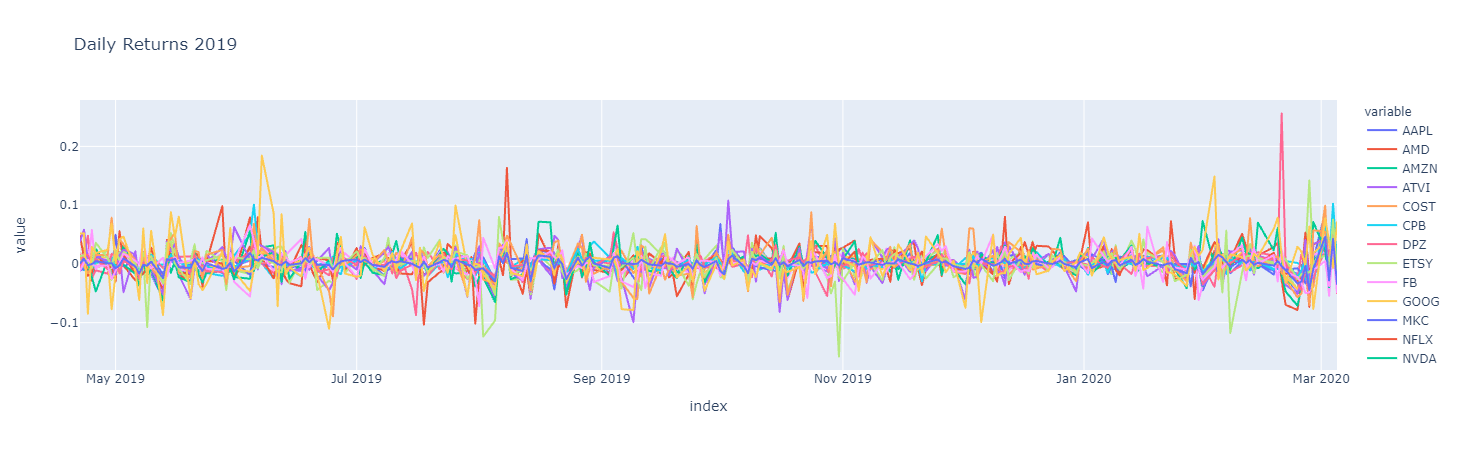

In [15]:
px.line(daily_returns, title="Daily Returns 2019")

In [16]:
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.head()

AAPL       AMD      AMZN      ATVI      COST       CPB  \
2019-04-22  1.003826  1.017824  1.014312  1.000883  0.990157  0.998477   
2019-04-23  1.017904  1.010597  1.033722  1.026490  0.998861  0.987814   
2019-04-24  1.016286  1.028302  1.021210  1.032230  1.008582  0.989845   
2019-04-25  1.006769  0.999035  1.021897  1.046578  0.998698  0.968901   
2019-04-26  1.002109  1.007346  1.048082  1.062693  0.992028  0.980960   

                 DPZ      ETSY        FB      GOOG  ...      NFLX      NVDA  \
2019-04-22  0.994357  1.002050  1.017777  1.009929  ...  1.047204  1.011541   
2019-04-23  1.009903  1.028864  1.030563  1.022243  ...  1.059747  1.023457   
2019-04-24  1.058296  1.042114  1.024170  1.015071  ...  1.038407  1.026141   
2019-04-25  1.032997  1.070347  1.083280  1.021159  ...  1.022173  1.002899   
2019-04-26  1.021749  1.067823  1.073856  1.028258  ...  1.040710  0.955931   

                OKTA      SHOP       PEP       PLD      TTWO      WING  \
2019-04-22  1.038269  1.015943  0.994572  0.991031  1.013004  0.988326   
2019-04-23  1.098679  1.011867  0.999685  1.008425  1.028102  0.990635   
2019-04-24  1.106001  0.995561  0.998584  1.023373  1.031849  0.997563   
2019-04-25  1.104805  0.992345  0.991819  1.025139  1.023804  0.997306   
2019-04-26  1.119917  1.007247  0.994179  1.033972  1.060723  0.993072   

                  ZM   S&P 500  
2019-04-22  1.051426  1.001012  
2019-04-23  1.106216  1.009862  
2019-04-24  1.012496  1.007649  
2019-04-25  1.041653  1.007277  
2019-04-26  1.060878  1.011996  

[5 rows x 21 columns]

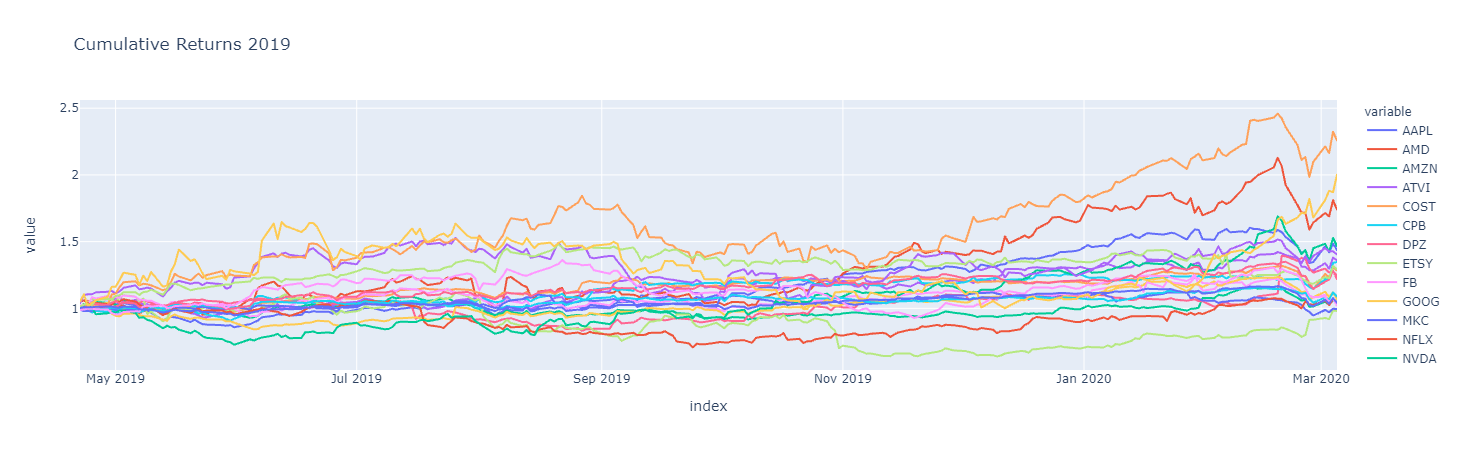

In [17]:
px.line(cumulative_returns, title="Cumulative Returns 2019")

In [18]:
standard_deviation = cumulative_returns.std()
standard_deviation

AAPL       0.219047
AMD        0.300882
AMZN       0.054477
ATVI       0.126971
COST       0.088161
CPB        0.095874
DPZ        0.100185
ETSY       0.136633
FB         0.067976
GOOG       0.097233
MKC        0.037472
NFLX       0.100759
NVDA       0.213648
OKTA       0.127832
SHOP       0.328925
PEP        0.038237
PLD        0.084185
TTWO       0.100162
WING       0.101434
ZM         0.208462
S&P 500    0.053062
dtype: float64

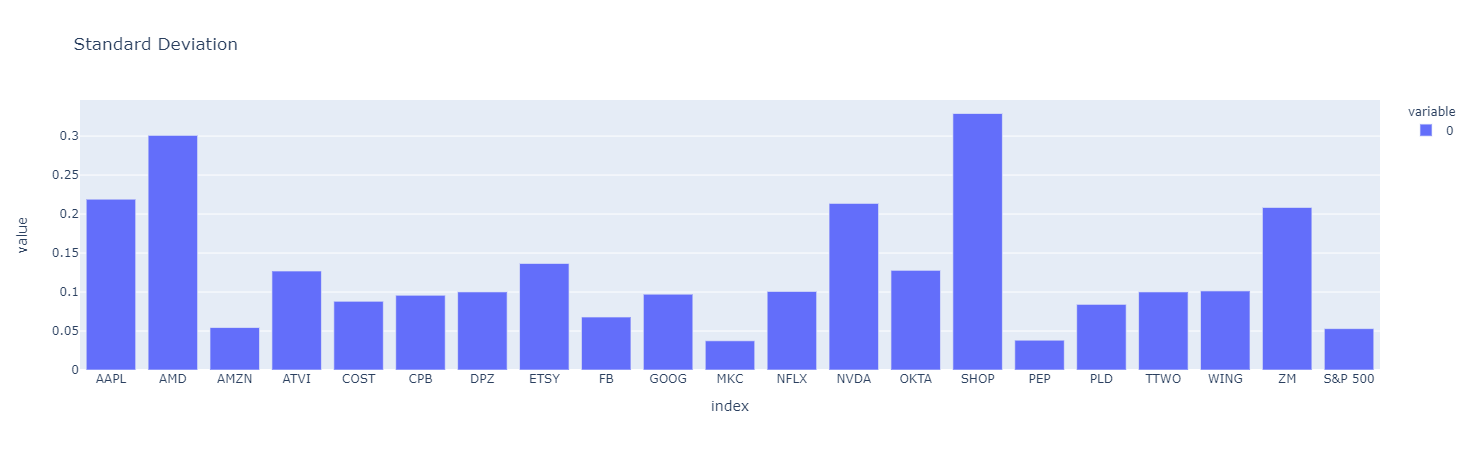

In [19]:
px.bar(standard_deviation, title="Standard Deviation")

In [20]:
daily_correlation = daily_returns.corr()
daily_correlation.head()

AAPL       AMD      AMZN      ATVI      COST       CPB       DPZ  \
AAPL  1.000000  0.498201  0.534313  0.538672  0.513905  0.293364  0.164647   
AMD   0.498201  1.000000  0.503031  0.408794  0.394205  0.216771  0.093814   
AMZN  0.534313  0.503031  1.000000  0.416066  0.422443  0.129542  0.103229   
ATVI  0.538672  0.408794  0.416066  1.000000  0.469520  0.232641  0.102004   
COST  0.513905  0.394205  0.422443  0.469520  1.000000  0.405616  0.194845   

          ETSY        FB      GOOG  ...      NFLX      NVDA      OKTA  \
AAPL  0.279232  0.546759  0.573592  ...  0.431305  0.652516  0.305675   
AMD   0.270063  0.355570  0.416634  ...  0.406011  0.629228  0.302675   
AMZN  0.310547  0.566578  0.541789  ...  0.449136  0.508980  0.349374   
ATVI  0.308263  0.458611  0.442598  ...  0.372476  0.505522  0.337403   
COST  0.206508  0.337092  0.387379  ...  0.284552  0.390759  0.247944   

          SHOP       PEP       PLD      TTWO      WING        ZM   S&P 500  
AAPL  0.405859  0.499013  0.456496  0.426396  0.227170  0.168572  0.820164  
AMD   0.391026  0.337674  0.334048  0.325318  0.204785  0.209942  0.629219  
AMZN  0.468039  0.379462  0.335633  0.299401  0.129482  0.273493  0.652861  
ATVI  0.395080  0.421086  0.394653  0.501482  0.153362  0.202678  0.583930  
COST  0.326785  0.640001  0.540101  0.365835  0.303566  0.170694  0.699346  

[5 rows x 21 columns]

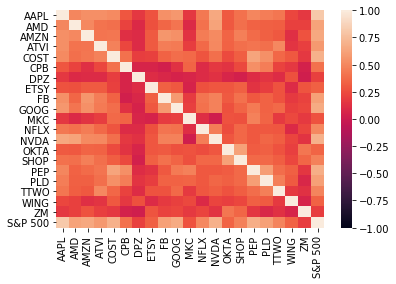

In [21]:
sns.heatmap(daily_correlation, vmin=-1,vmax=1)

In [22]:
# Calculate covariance of stocks against the S&P500 performance
AAPLcovariance = daily_returns["AAPL"].cov(daily_returns["S&P 500"])
AMDcovariance = daily_returns["AMD"].cov(daily_returns["S&P 500"])
AMZNcovariance = daily_returns["AMZN"].cov(daily_returns["S&P 500"])
ATVIcovariance = daily_returns["ATVI"].cov(daily_returns["S&P 500"])
COSTcovariance = daily_returns["COST"].cov(daily_returns["S&P 500"])
CPBcovariance = daily_returns["CPB"].cov(daily_returns["S&P 500"])
DPZcovariance = daily_returns["DPZ"].cov(daily_returns["S&P 500"])
ETSYcovariance = daily_returns["ETSY"].cov(daily_returns["S&P 500"])
FBcovariance = daily_returns["FB"].cov(daily_returns["S&P 500"])
GOOGcovariance = daily_returns["GOOG"].cov(daily_returns["S&P 500"])
MKCcovariance = daily_returns["MKC"].cov(daily_returns["S&P 500"])
NFLXcovariance = daily_returns["NFLX"].cov(daily_returns["S&P 500"])
NVDAcovariance = daily_returns["NVDA"].cov(daily_returns["S&P 500"])
OKTAcovariance = daily_returns["OKTA"].cov(daily_returns["S&P 500"])
SHOPcovariance = daily_returns["SHOP"].cov(daily_returns["S&P 500"])
PEPcovariance = daily_returns["PEP"].cov(daily_returns["S&P 500"])
PLDcovariance = daily_returns["PLD"].cov(daily_returns["S&P 500"])
TTWOcovariance = daily_returns["TTWO"].cov(daily_returns["S&P 500"])
WINGcovariance = daily_returns["WING"].cov(daily_returns["S&P 500"])
ZMcovariance = daily_returns["ZM"].cov(daily_returns["S&P 500"])


In [23]:
AAPLvariance = daily_returns['AAPL'].var()
FBvariance = daily_returns['FB'].var()
AMZNvariance = daily_returns['AMZN'].var()
NFLXvariance = daily_returns['NFLX'].var()
GOOGvariance = daily_returns['GOOG'].var()
SHOPvariance = daily_returns['SHOP'].var()
NVDAvariance = daily_returns['NVDA'].var()
AMDvariance = daily_returns['AMD'].var()
PEPvariance = daily_returns['PEP'].var()
MKCvariance = daily_returns['MKC'].var()
DPZvariance = daily_returns['DPZ'].var()
WINGvariance = daily_returns['WING'].var()
ATVIvariance = daily_returns['ATVI'].var()
COSTvariance = daily_returns['COST'].var()
CPBvariance = daily_returns['CPB'].var()
ETSYvariance = daily_returns['ETSY'].var()
OKTAvariance = daily_returns['OKTA'].var()
PLDvariance = daily_returns['PLD'].var()
TTWOvariance = daily_returns['TTWO'].var()
ZMvariance = daily_returns['ZM'].var()

In [24]:
AAPLbeta = AAPLcovariance / AAPLvariance
print(f'Beta of AAPL is {AAPLbeta}')

FBbeta = FBcovariance / FBvariance
print(f'Beta of FB is {FBbeta}')

AMZNbeta = AMZNcovariance / AMZNvariance
print(f'Beta of AMZN is {AMZNbeta}')

NFLXbeta = NFLXcovariance / NFLXvariance
print(f'Beta of NFLX is {NFLXbeta}')

GOOGbeta = GOOGcovariance / GOOGvariance
print(f'Beta of GOOG is {GOOGbeta}')

SHOPbeta = SHOPcovariance / SHOPvariance
print(f'Beta of SHOP is {SHOPbeta}')

NVDAbeta = NVDAcovariance / NVDAvariance
print(f'Beta of NVDA is {NVDAbeta}')

AMDbeta = AMDcovariance / AMDvariance
print(f'Beta of AMD is {AMDbeta}')

PEPbeta = PEPcovariance / PEPvariance
print(f'Beta of PEP is {PEPbeta}')

MKCbeta = MKCcovariance / MKCvariance
print(f'Beta of MKC is {MKCbeta}')

DPZbeta = DPZcovariance / DPZvariance
print(f'Beta of DPZ is {DPZbeta}')

WINGbeta = WINGcovariance / WINGvariance
print(f'Beta of WING is {WINGbeta}')

ATVIbeta = ATVIcovariance / ATVIvariance
print(f'Beta of ATVI is {ATVIbeta}')

COSTbeta =  COSTcovariance / COSTvariance
print(f'Beta of COST is {COSTbeta}')

CPBbeta = CPBcovariance / CPBvariance
print(f'Beta of CPB is {CPBbeta}')

ETSYbeta = ETSYcovariance / ETSYvariance
print(f'Beta of ETSY is {ETSYbeta}')

OKTAbeta = OKTAcovariance / OKTAvariance
print(f'Beta of OKTA is {OKTAbeta}')

PLDbeta = PLDcovariance / PLDvariance
print(f'Beta of PLD is {PLDbeta}')

TTWObeta = TTWOcovariance / TTWOvariance
print(f'Beta of TTWO is {TTWObeta}')

ZMbeta = ZMcovariance / ZMvariance
print(f'Beta of ZM is {ZMbeta}')

Beta of AAPL is 0.4593187227386087
Beta of FB is 0.3592217454092745
Beta of AMZN is 0.457569353198044
Beta of NFLX is 0.2416918286009362
Beta of GOOG is 0.4091747689668632
Beta of SHOP is 0.162729936148186
Beta of NVDA is 0.28012766996832567
Beta of AMD is 0.21036897214552272
Beta of PEP is 0.6753877180641131
Beta of MKC is 0.22726164871217294
Beta of DPZ is 0.08746700395365109
Beta of WING is 0.17079923498237654
Beta of ATVI is 0.3073011961685933
Beta of COST is 0.5272880705312614
Beta of CPB is 0.26379862229452083
Beta of ETSY is 0.11259216992344309
Beta of OKTA is 0.13281930237333386
Beta of PLD is 0.4403622592493841
Beta of TTWO is 0.25361976680814957
Beta of ZM is 0.05188434616920592
